In [1]:
# All the imports
from skimage import io
from skimage.color import rgb2gray,rgb2hsv
import matplotlib.pyplot as plt
from matplotlib.pyplot import bar
from skimage.exposure import histogram
import os
import numpy as np
import cv2

In [2]:
# From the labs:
# Show the figures / plots inside the notebook
def show_images(images,titles=None):
    #This function is used to show image(s) with titles by sending an array of images and an array of associated titles.
    # images[0] will be drawn with the title titles[0] if exists
    # You aren't required to understand this function, use it as-is.
    n_ims = len(images)
    if titles is None: titles = ['(%d)' % i for i in range(1,n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image,title in zip(images,titles):
        a = fig.add_subplot(1,n_ims,n)
        if image.ndim == 2: 
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
    plt.show() 


def showHist(img):
    # An "interface" to matplotlib.axes.Axes.hist() method
    plt.figure()
    imgHist = histogram(img, nbins=256)
    
    bar(imgHist[1].astype(np.uint8), imgHist[0], width=0.8, align='center')


In [3]:
# 
def reorderPoints(points,):
    # print('points= ',points)
    print(len(points))
    points = points.reshape((len(points), 2))
    # The paper should only have 4 points 
    newPoints = np.zeros((4, 1, 2), dtype=np.int32)
    add = points.sum(1)

    newPoints[0] = points[np.argmin(add)]
    newPoints[3] =points[np.argmax(add)]
    diff = np.diff(points, axis=1)
    newPoints[1] =points[np.argmin(diff)]
    newPoints[2] = points[np.argmax(diff)]
    newPoints
    return newPoints

# 
def getBiggestContour(contours):
    biggest = np.array([])
    max_area = 0
    for i in contours:
        area = cv2.contourArea(i)
        if area > 5000:
            peri = cv2.arcLength(i, True)
            approx = cv2.approxPolyDP(i, 0.02 * peri, True)
            if area > max_area:
                biggest = approx
                max_area = area
    return biggest,max_area


def drawRectangle(img,biggest,thickness):
    cv2.line(img, (biggest[0][0][0], biggest[0][0][1]), (biggest[1][0][0], biggest[1][0][1]), (0, 255, 0), thickness)
    cv2.line(img, (biggest[0][0][0], biggest[0][0][1]), (biggest[2][0][0], biggest[2][0][1]), (0, 255, 0), thickness)
    cv2.line(img, (biggest[3][0][0], biggest[3][0][1]), (biggest[2][0][0], biggest[2][0][1]), (0, 255, 0), thickness)
    cv2.line(img, (biggest[3][0][0], biggest[3][0][1]), (biggest[1][0][0], biggest[1][0][1]), (0, 255, 0), thickness)

    return img

In [4]:
# This function 
def getPageWarped(img, filename, thresh1=180):
    notWarped = True
    # Get image dimensions
    imgHeight = img.shape[0]
    imgWidth = img.shape[1]

    if imgWidth > 1500:
        img = cv2.resize(img, width=1500)

    # First: Convert the image from BGR (Yes, images in OpenCV 2 are in BGR not RGB) to Grayscale
    grayImg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Second: Add a Gaussian Filter with a 5*5 Kernel with Sigma X=1 (Sigma Y=0 by default) 
    # to smooth the image and remove random noise.
    bluredImg = cv2.GaussianBlur(grayImg, (5, 5), 1)

    # Third: Add a Median Filter with a 3*3 Kernal to remove salt and pepper noise.
    bluredImg = cv2.medianBlur(bluredImg, 3)

    # Fourth: Apply Canny Edge Detection with thresholds:  &  for the hysteresis procedure.
    thresholdedImg = cv2.Canny(bluredImg, thresh1,255) # 180 -> 255

    # Fifth: Apply Closing with a kernel of 7*7 to connect any disconnected edges.
    kernel = np.ones((7, 7))
    dilatedImg = cv2.dilate(thresholdedImg, kernel, iterations=2)
    thresholdedImg = cv2.erode(dilatedImg, kernel, iterations=1)

    # Sixth: Find all contours.
    imgWithContours = img.copy()
    contours, hierarchy = cv2.findContours(thresholdedImg, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(imgWithContours, contours, -1, (0, 255, 0), 10)

    # Seventh: Find the biggest contour.
    biggestContour, maxArea = getBiggestContour(contours)
    print('Max Area: ', maxArea)
    print('Total Area:', imgHeight*imgWidth)
    print('Condition: ',biggestContour.size != 0 and maxArea>0.1*imgHeight*imgWidth)

    if biggestContour.size != 0 and maxArea>0.15*imgHeight*imgWidth:
        biggestContour= reorderPoints(biggestContour)
        imgWithBiggestContour = img.copy()
        cv2.drawContours(imgWithBiggestContour, biggestContour, -1, (0, 255, 0), 20)
        imgWithBiggestContour = drawRectangle(imgWithBiggestContour,biggestContour,2)
        pts1 = np.float32(biggestContour)
        pts2 = np.float32([[0, 0],[imgWidth, 0], [0, imgHeight],[imgWidth, imgHeight]])
        matrix = cv2.getPerspectiveTransform(pts1, pts2)
        WarpedColoredImage = cv2.warpPerspective(img, matrix, (imgWidth, imgHeight))

        WarpedColoredImage=WarpedColoredImage[20:WarpedColoredImage.shape[0] - 20, 20:WarpedColoredImage.shape[1] - 20]
        WarpedColoredImage = cv2.resize(WarpedColoredImage,(imgWidth,imgHeight))

        imageArr = ([img,grayImg,thresholdedImg,imgWithContours,
                        imgWithBiggestContour,WarpedColoredImage])
        notWarped = False
    
    # elif thresh1>100:
    #     imageArr = getPageWarped(img, filename, thresh1-10)
    else:
        imageArr = ([img,grayImg,thresholdedImg,imgWithContours, img, img])
        notWarped = True

    lables = ["Original","Gray","Threshold with Canny","Contours","Biggest Contour","Warp Prespective"]
    for i in range(len(imageArr)):
        imageArr[i] = cv2.cvtColor(imageArr[i],cv2.COLOR_BGR2RGB)
        cv2.imwrite('Output_Images/'+lables[i]+'_'+filename,imageArr[i])
    show_images(imageArr, lables)

    return imageArr, notWarped

Max Area:  363416.0
Total Area: 921600
Condition:  True
4


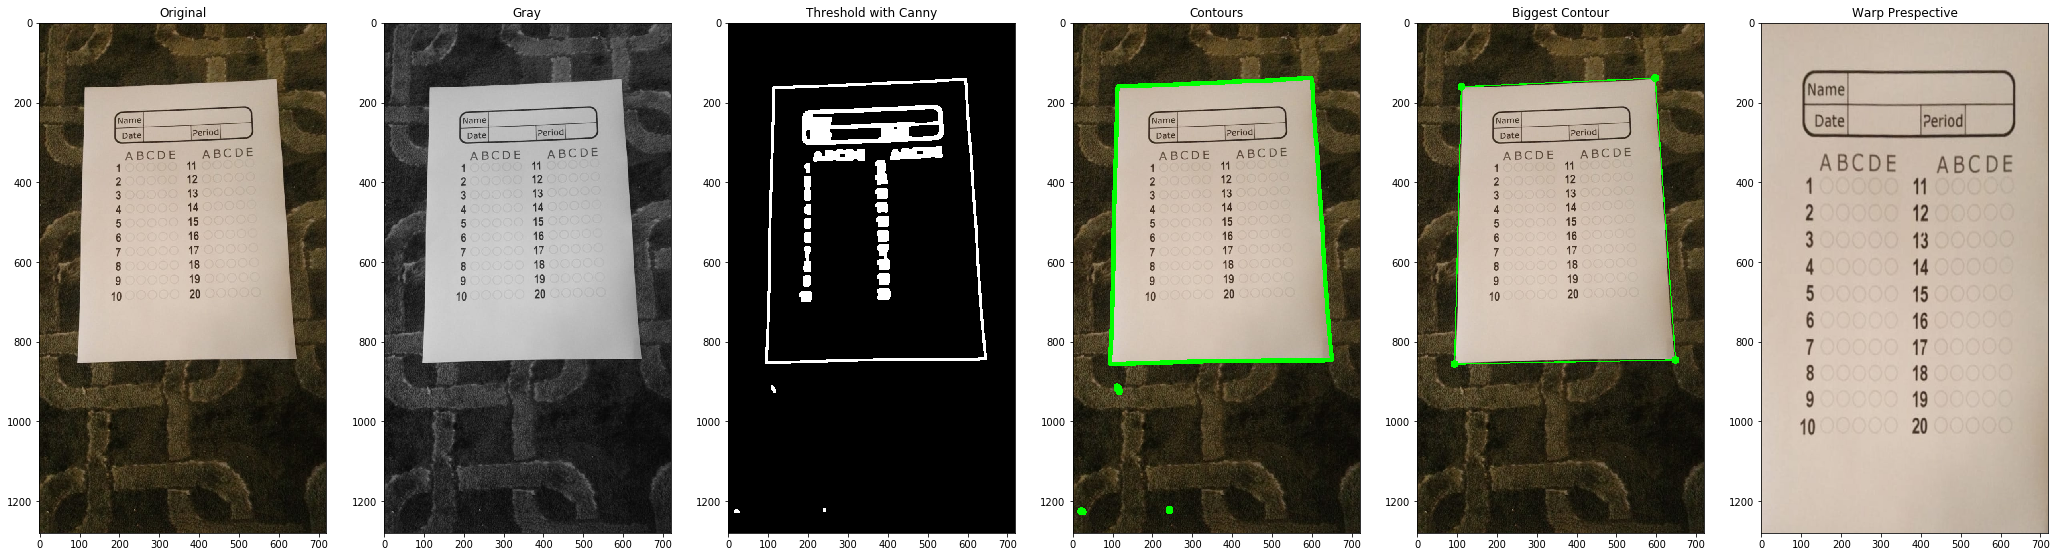

Max Area:  377439.5
Total Area: 921600
Condition:  True
4


In [5]:
files2 = ['1_4.jpeg','2_3.jpeg','3_3.jpeg','4_3.jpeg','5_1.jpg']
#files2 = ['5_1.jpg']
for file in files2:
    img = cv2.imread('TestCases/'+file)
    getPageWarped(img,file)

In [ ]:
files2 = ['1.jpeg','2.jpeg','3.jpeg','6.jpeg','7.jpeg']
#files2 = ['1.jpeg','2.jpeg','3.jpeg','4.jpeg','5.jpeg','6.jpeg','7.jpeg']
#files2 = ['1.jpeg','2.jpeg']
for file in files2:
    img = cv2.imread('LatestHardTestCases/'+file)
    getPageWarped(img,file)